In [4]:
!pip install jcopdl
!pip install gdown

In [8]:
!gdown https://drive.google.com/uc?id=1aRcs33BQlhNu-Br9mcrIKIHrSDgKZNej

Downloading...
From: https://drive.google.com/uc?id=1aRcs33BQlhNu-Br9mcrIKIHrSDgKZNej
To: /content/panorama.zip
100% 25.7M/25.7M [00:00<00:00, 47.7MB/s]


In [ ]:
!unzip /content/panorama.zip

In [10]:
import jcopdl
jcopdl.__version__

'1.1.9'

In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Dataset & DataLoader

In [13]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import MultilabelDataset

In [31]:
bs = 64
crops_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crops_size, scale=(0.7, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set = MultilabelDataset("data/train_label.csv", "data/train/", transform=train_transform)
trainloader =  DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

test_set = MultilabelDataset("data/test_label.csv", "data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [32]:
label2cat = train_set.classes
label2cat

['desert', 'mountains', 'sea', 'sunset', 'trees']

# Arsitektur dan Config

In [33]:
from torchvision.models import mobilenet_v2

mnet = mobilenet_v2(pretrained=True)

for param in mnet.parameters():
    param.requires_grad = False

In [17]:
mnet

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [34]:
mnet.classifier = nn.Sequential(
    nn.Linear(1280, 5),
    nn.Sigmoid()
)

In [35]:
class CustomMobilenetV2(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.mnet = mnet = mobilenet_v2(pretrained=True)
        self.freeze()
        self.mnet.classifier = nn.Sequential(
            nn.Linear(1280, output_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.mnet(x)
    
    def freeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = False
            
    def unfreeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = True

In [36]:
config = set_config({
    "output_size": len(train_set.classes),
    "batch_size": bs,
    "crop_size": crops_size
})

##  Phase 1: Adaptation (lr = standard + patience kecil)

In [37]:
model = CustomMobilenetV2(config.output_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=2, outdir="model")

In [38]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.4928 | Test_cost  = 0.3795 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.3444 | Test_cost  = 0.3060 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.2991 | Test_cost  = 0.2798 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.2756 | Test_cost  = 0.2597 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.2571 | Test_cost  = 0.2616 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2597


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f03229203b0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f03229203b0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.2475 | Test_cost  = 0.2504 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.2390 | Test_cost  = 0.2338 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.2349 | Test_cost  = 0.2415 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2338


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.2291 | Test_cost  = 0.2348 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2338
==> Execute Early Stopping at epoch: 9 | Best test_cost: 0.2338
==> Best model is saved at model


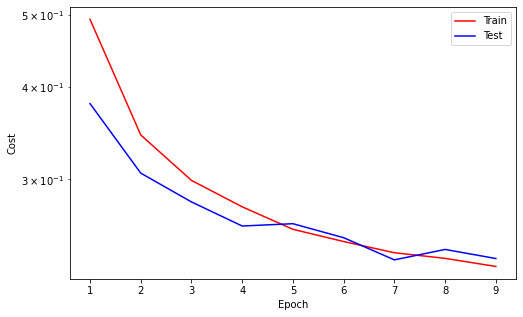

In [39]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
        
    # Logging 
    callback.log(train_cost, test_cost)
    
    # Checkpoint
    callback.save_checkpoint()
    
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Phase 2: Fine-Tuning (lr dikecilkan, patience ditambah)

In [40]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback.reset_early_stop()
callback.early_stop_patience = 5

Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.2165 | Test_cost  = 0.2257 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.1985 | Test_cost  = 0.2086 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.1811 | Test_cost  = 0.2004 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.1767 | Test_cost  = 0.1938 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.1639 | Test_cost  = 0.1897 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.1563 | Test_cost  = 0.1868 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.1515 | Test_cost  = 0.1824 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.1446 | Test_cost  = 0.1772 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.1401 | Test_cost  = 0.1762 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.1356 | Test_cost  = 0.1717 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.1297 | Test_cost  = 0.1728 | 


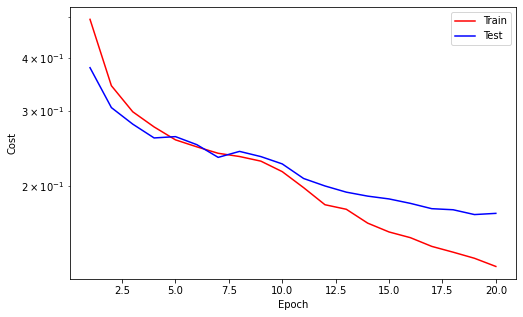

==> EarlyStop patience =  1 | Best test_cost: 0.1717


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.1289 | Test_cost  = 0.1746 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1717


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.1235 | Test_cost  = 0.1681 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.1172 | Test_cost  = 0.1681 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.1130 | Test_cost  = 0.1684 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1681


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.1125 | Test_cost  = 0.1700 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1681


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.1102 | Test_cost  = 0.1666 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.1032 | Test_cost  = 0.1626 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.1027 | Test_cost  = 0.1694 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1626


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.0963 | Test_cost  = 0.1624 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.0973 | Test_cost  = 0.1592 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.0967 | Test_cost  = 0.1572 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.0904 | Test_cost  = 0.1608 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1572


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f03229203b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f03229203b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers


Train:   0%|          | 0/26 [00:00<?, ?it/s]

    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.0884 | Test_cost  = 0.1641 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1572


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.0913 | Test_cost  = 0.1527 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 0.0837 | Test_cost  = 0.1622 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1527


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 0.0820 | Test_cost  = 0.1598 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1527


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 0.0816 | Test_cost  = 0.1592 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1527


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 0.0784 | Test_cost  = 0.1627 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1527


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 0.0739 | Test_cost  = 0.1526 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:10<?, ?it/s]


Epoch    40
Train_cost  = 0.0727 | Test_cost  = 0.1611 | 


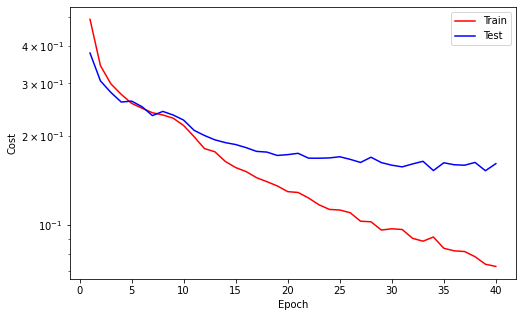

==> EarlyStop patience =  1 | Best test_cost: 0.1526


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 0.0690 | Test_cost  = 0.1545 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1526


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 0.0739 | Test_cost  = 0.1579 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1526


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 0.0716 | Test_cost  = 0.1609 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1526


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 0.0665 | Test_cost  = 0.1602 | 
==> EarlyStop patience =  5 | Best test_cost: 0.1526
==> Execute Early Stopping at epoch: 44 | Best test_cost: 0.1526
==> Best model is saved at model


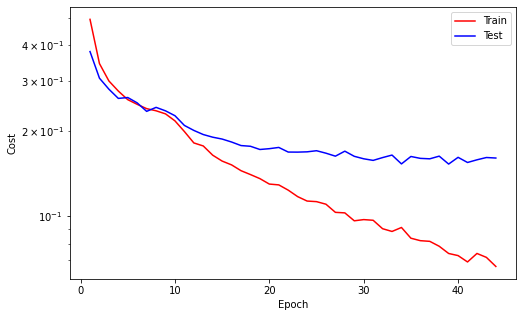

In [41]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
        
    # Logging 
    callback.log(train_cost, test_cost)
    
    # Checkpoint
    callback.save_checkpoint()
    
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Predict

In [42]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [43]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = (output > 0.5).to(torch.float32)
preds

tensor([[0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 1., 1., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 1., 1., 0.],
        [0

# Sanity Check

In [44]:
def conver_to_label(x):
    return [label for pred, label in zip(x, label2cat) if pred==1]

def inverse_norm(img):
    img[0, :, :] = img[0, :, :] * 0.229 + 0.485
    img[1, :, :] = img[1, :, :] * 0.224 + 0.456
    img[2, :, :] = img[2, :, :] * 0.225 + 0.406
    return img

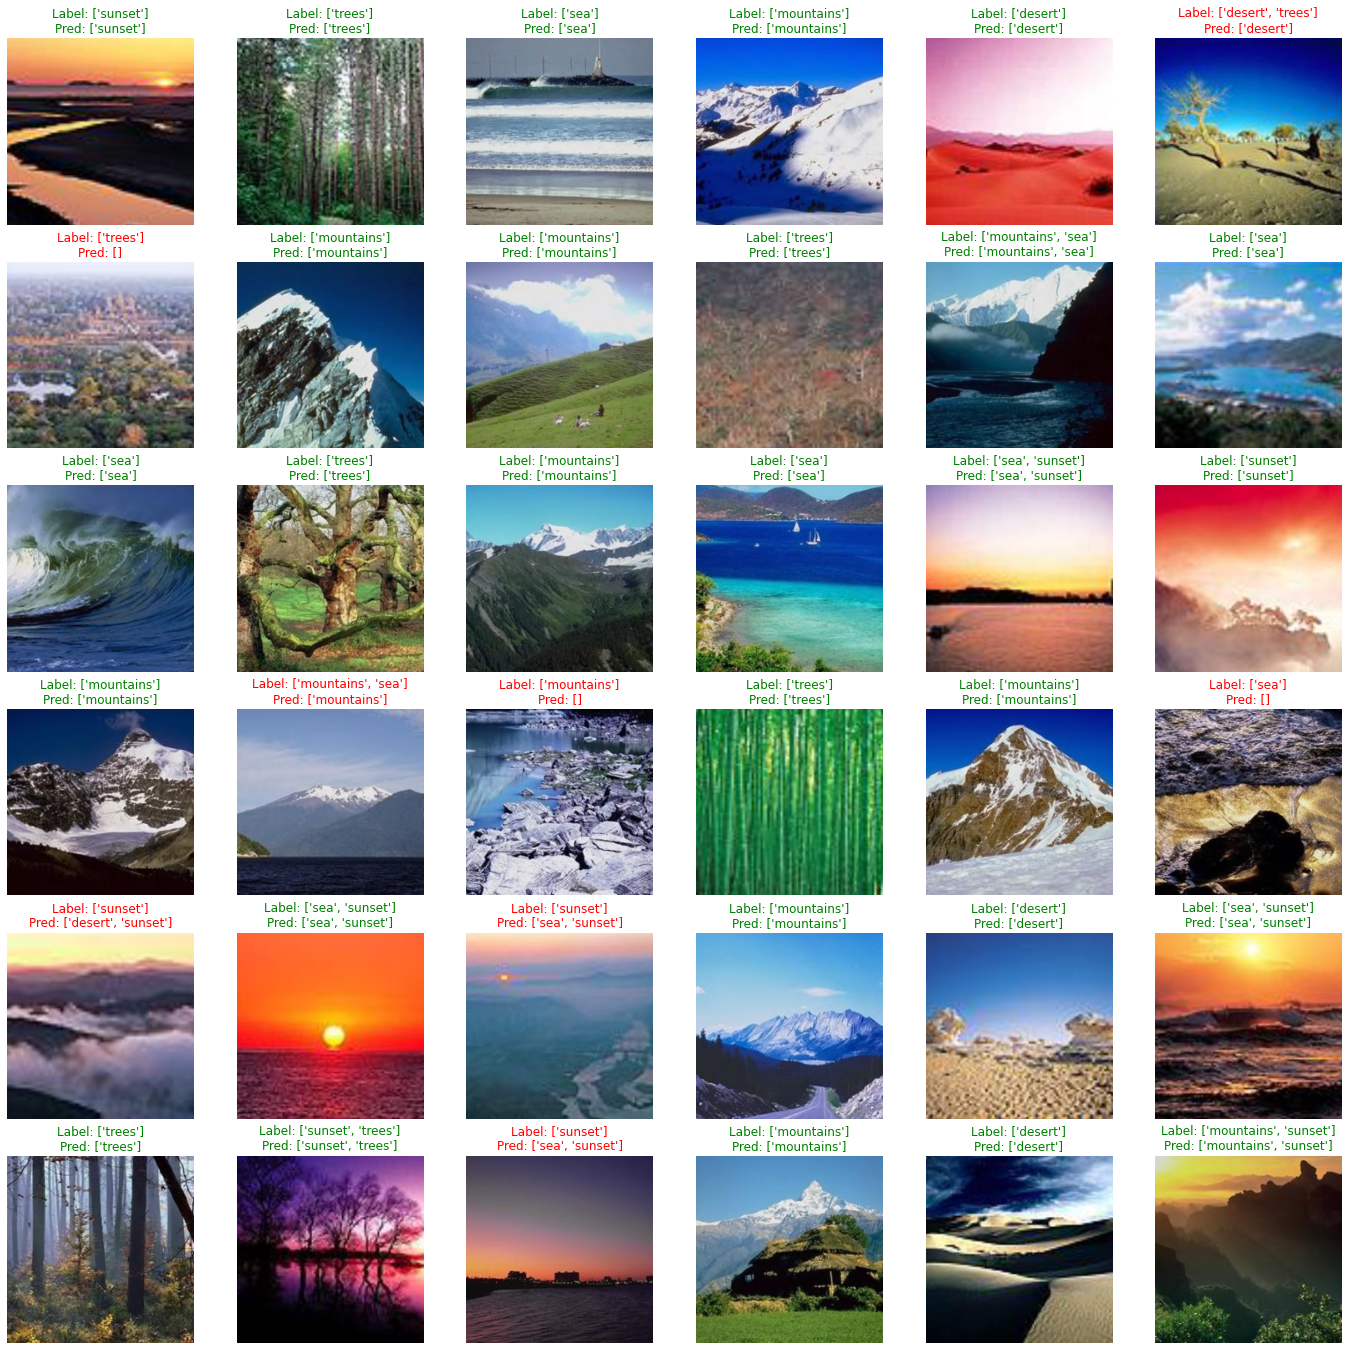

In [45]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(inverse_norm(img).permute(1, 2, 0).cpu())
    font = {"color":'r'} if (pred != label).any() else {"color":'g'}
    label, pred = conver_to_label(label), conver_to_label(pred)
    ax.set_title(f"Label: {label}\nPred: {pred}", fontdict=font);
    ax.axis('off');

In [46]:
!zip -r model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/configs.pth (deflated 51%)
  adding: content/model/weights_best.pth (deflated 8%)
  adding: content/model/logs.pth (deflated 22%)
